In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import math
import random 
import os
# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Signature Analysis - SBS

## 1. Import data

### 1.1 Healthy crypts mutational signatures 
Lee-Six, Henry, et al. "The landscape of somatic mutation in normal colorectal epithelial cells." Nature 574.7779 (2019): 532-537.
Eleven signatures (SBS1, SBS5, SBS18, DBS2, DBS4, DBS6, DBS9, DBS11, ID1, ID2 and ID5) were found in over 85% of crypts.



In [2]:
signatures=pd.read_csv(current_dir+'/Data/all_signatures_coloncrypts.csv', sep=',') 

### 1.2 POLE  signatures
Robinson, Philip S., et al. "Increased somatic mutation burdens in normal human cells due to defective DNA polymerases." Nature genetics 53.10 (2021): 1434-1442.

In [3]:
sbs_pole=pd.read_csv(current_dir+'/Data/pcawg_avtriprobs_onlypolesigs.csv')

### 1.3 MSI CRC  signatures
Cornish, Alex J., et al. "Whole genome sequencing of 2,023 colorectal cancers reveals mutational landscapes, new driver genes and immune interactions." bioRxiv (2022): 2022-11.



In [4]:
# For MSI, using GEL data

signatures_MSI=['SBS1','SBS5','SBS44','SBS15','SBS26']
vector_MSI_GEL=[0.1103,0.27518,0.2559,0.06766,0.07668]
vector_MSI_GEL=np.asarray(vector_MSI_GEL)/sum(np.asarray(vector_MSI_GEL))


### 1.4  APC Genomic Context 

Import FASTA sequence (coding only) and split into regions from Genome Browswe
https://genome.ucsc.edu/cgi-bin/hgGene?hgsid=2070446478_ES8PJgBFgaCtkDStj19LqObVAiKN&hgg_do_getMrnaSeq=1&hgg_gene=ENST00000257430.9

In [5]:
# APC CDS
apc_cds='ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCACTGAAGATGGAGAACTCAAATCTTCGACAAGAGCTAGAAGATAATTCCAATCATCTTACAAAACTGGAAACTGAGGCATCTAATATGAAGGAAGTACTTAAACAACTACAAGGAAGTATTGAAGATGAAGCTATGGCTTCTTCTGGACAGATTGATTTATTAGAGCGTCTTAAAGAGCTTAACTTAGATAGCAGTAATTTCCCTGGAGTAAAACTGCGGTCAAAAATGTCCCTCCGTTCTTATGGAAGCCGGGAAGGATCTGTATCAAGCCGTTCTGGAGAGTGCAGTCCTGTTCCTATGGGTTCATTTCCAAGAAGAGGGTTTGTAAATGGAAGCAGAGAAAGTACTGGATATTTAGAAGAACTTGAGAAAGAGAGGTCATTGCTTCTTGCTGATCTTGACAAAGAAGAAAAGGAAAAAGACTGGTATTACGCTCAACTTCAGAATCTCACTAAAAGAATAGATAGTCTTCCTTTAACTGAAAATTTTTCCTTACAAACAGATATGACCAGAAGGCAATTGGAATATGAAGCAAGGCAAATCAGAGTTGCGATGGAAGAACAACTAGGTACCTGCCAGGATATGGAAAAACGAGCACAGCGAAGAATAGCCAGAATTCAGCAAATCGAAAAGGACATACTTCGTATACGACAGCTTTTACAGTCCCAAGCAACAGAAGCAGAGAGGTCATCTCAGAACAAGCATGAAACCGGCTCACATGATGCTGAGCGGCAGAATGAAGGTCAAGGAGTGGGAGAAATCAACATGGCAACTTCTGGTAATGGTCAGGGTTCAACTACACGAATGGACCATGAAACAGCCAGTGTTTTGAGTTCTAGTAGCACACACTCTGCACCTCGAAGGCTGACAAGTCATCTGGGAACCAAGGTGGAAATGGTGTATTCATTGTTGTCAATGCTTGGTACTCATGATAAGGATGATATGTCGCGAACTTTGCTAGCTATGTCTAGCTCCCAAGACAGCTGTATATCCATGCGACAGTCTGGATGTCTTCCTCTCCTCATCCAGCTTTTACATGGCAATGACAAAGACTCTGTATTGTTGGGAAATTCCCGGGGCAGTAAAGAGGCTCGGGCCAGGGCCAGTGCAGCACTCCACAACATCATTCACTCACAGCCTGATGACAAGAGAGGCAGGCGTGAAATCCGAGTCCTTCATCTTTTGGAACAGATACGCGCTTACTGTGAAACCTGTTGGGAGTGGCAGGAAGCTCATGAACCAGGCATGGACCAGGACAAAAATCCAATGCCAGCTCCTGTTGAACATCAGATCTGTCCTGCTGTGTGTGTTCTAATGAAACTTTCATTTGATGAAGAGCATAGACATGCAATGAATGAACTAGGGGGACTACAGGCCATTGCAGAATTATTGCAAGTGGACTGTGAAATGTATGGGCTTACTAATGACCACTACAGTATTACACTAAGACGATATGCTGGAATGGCTTTGACAAACTTGACTTTTGGAGATGTAGCCAACAAGGCTACGCTATGCTCTATGAAAGGCTGCATGAGAGCACTTGTGGCCCAACTAAAATCTGAAAGTGAAGACTTACAGCAGGTTATTGCGAGTGTTTTGAGGAATTTGTCTTGGCGAGCAGATGTAAATAGTAAAAAGACGTTGCGAGAAGTTGGAAGTGTGAAAGCATTGATGGAATGTGCTTTAGAAGTTAAAAAGGAATCAACCCTCAAAAGCGTATTGAGTGCCTTATGGAATTTGTCAGCACATTGCACTGAGAATAAAGCTGATATATGTGCTGTAGATGGTGCACTTGCATTTTTGGTTGGCACTCTTACTTACCGGAGCCAGACAAACACTTTAGCCATTATTGAAAGTGGAGGTGGGATATTACGGAATGTGTCCAGCTTGATAGCTACAAATGAGGACCACAGGCAAATCCTAAGAGAGAACAACTGTCTACAAACTTTATTACAACACTTAAAATCTCATAGTTTGACAATAGTCAGTAATGCATGTGGAACTTTGTGGAATCTCTCAGCAAGAAATCCTAAAGACCAGGAAGCATTATGGGACATGGGGGCAGTTAGCATGCTCAAGAACCTCATTCATTCAAAGCACAAAATGATTGCTATGGGAAGTGCTGCAGCTTTAAGGAATCTCATGGCAAATAGGCCTGCGAAGTACAAGGATGCCAATATTATGTCTCCTGGCTCAAGCTTGCCATCTCTTCATGTTAGGAAACAAAAAGCCCTAGAAGCAGAATTAGATGCTCAGCACTTATCAGAAACTTTTGACAATATAGACAATTTAAGTCCCAAGGCATCTCATCGTAGTAAGCAGAGACACAAGCAAAGTCTCTATGGTGATTATGTTTTTGACACCAATCGACATGATGATAATAGGTCAGACAATTTTAATACTGGCAACATGACTGTCCTTTCACCATATTTGAATACTACAGTGTTACCCAGCTCCTCTTCATCAAGAGGAAGCTTAGATAGTTCTCGTTCTGAAAAAGATAGAAGTTTGGAGAGAGAACGCGGAATTGGTCTAGGCAACTACCATCCAGCAACAGAAAATCCAGGAACTTCTTCAAAGCGAGGTTTGCAGATCTCCACCACTGCAGCCCAGATTGCCAAAGTCATGGAAGAAGTGTCAGCCATTCATACCTCTCAGGAAGACAGAAGTTCTGGGTCTACCACTGAATTACATTGTGTGACAGATGAGAGAAATGCACTTAGAAGAAGCTCTGCTGCCCATACACATTCAAACACTTACAATTTCACTAAGTCGGAAAATTCAAATAGGACATGTTCTATGCCTTATGCCAAATTAGAATACAAGAGATCTTCAAATGATAGTTTAAATAGTGTCAGTAGTAGTGATGGTTATGGTAAAAGAGGTCAAATGAAACCCTCGATTGAATCCTATTCTGAAGATGATGAAAGTAAGTTTTGCAGTTATGGTCAATACCCAGCCGACCTAGCCCATAAAATACATAGTGCAAATCATATGGATGATAATGATGGAGAACTAGATACACCAATAAATTATAGTCTTAAATATTCAGATGAGCAGTTGAACTCTGGAAGGCAAAGTCCTTCACAGAATGAAAGATGGGCAAGACCCAAACACATAATAGAAGATGAAATAAAACAAAGTGAGCAAAGACAATCAAGGAATCAAAGTACAACTTATCCTGTTTATACTGAGAGCACTGATGATAAACACCTCAAGTTCCAACCACATTTTGGACAGCAGGAATGTGTTTCTCCATACAGGTCACGGGGAGCCAATGGTTCAGAAACAAATCGAGTGGGTTCTAATCATGGAATTAATCAAAATGTAAGCCAGTCTTTGTGTCAAGAAGATGACTATGAAGATGATAAGCCTACCAATTATAGTGAACGTTACTCTGAAGAAGAACAGCATGAAGAAGAAGAGAGACCAACAAATTATAGCATAAAATATAATGAAGAGAAACGTCATGTGGATCAGCCTATTGATTATAGTTTAAAATATGCCACAGATATTCCTTCATCACAGAAACAGTCATTTTCATTCTCAAAGAGTTCATCTGGACAAAGCAGTAAAACCGAACATATGTCTTCAAGCAGTGAGAATACGTCCACACCTTCATCTAATGCCAAGAGGCAGAATCAGCTCCATCCAAGTTCTGCACAGAGTAGAAGTGGTCAGCCTCAAAAGGCTGCCACTTGCAAAGTTTCTTCTATTAACCAAGAAACAATACAGACTTATTGTGTAGAAGATACTCCAATATGTTTTTCAAGATGTAGTTCATTATCATCTTTGTCATCAGCTGAAGATGAAATAGGATGTAATCAGACGACACAGGAAGCAGATTCTGCTAATACCCTGCAAATAGCAGAAATAAAAGAAAAGATTGGAACTAGGTCAGCTGAAGATCCTGTGAGCGAAGTTCCAGCAGTGTCACAGCACCCTAGAACCAAATCCAGCAGACTGCAGGGTTCTAGTTTATCTTCAGAATCAGCCAGGCACAAAGCTGTTGAATTTTCTTCAGGAGCGAAATCTCCCTCCAAAAGTGGTGCTCAGACACCCAAAAGTCCACCTGAACACTATGTTCAGGAGACCCCACTCATGTTTAGCAGATGTACTTCTGTCAGTTCACTTGATAGTTTTGAGAGTCGTTCGATTGCCAGCTCCGTTCAGAGTGAACCATGCAGTGGAATGGTAAGTGGCATTATAAGCCCCAGTGATCTTCCAGATAGCCCTGGACAAACCATGCCACCAAGCAGAAGTAAAACACCTCCACCACCTCCTCAAACAGCTCAAACCAAGCGAGAAGTACCTAAAAATAAAGCACCTACTGCTGAAAAGAGAGAGAGTGGACCTAAGCAAGCTGCAGTAAATGCTGCAGTTCAGAGGGTCCAGGTTCTTCCAGATGCTGATACTTTATTACATTTTGCCACGGAAAGTACTCCAGATGGATTTTCTTGTTCATCCAGCCTGAGTGCTCTGAGCCTCGATGAGCCATTTATACAGAAAGATGTGGAATTAAGAATAATGCCTCCAGTTCAGGAAAATGACAATGGGAATGAAACAGAATCAGAGCAGCCTAAAGAATCAAATGAAAACCAAGAGAAAGAGGCAGAAAAAACTATTGATTCTGAAAAGGACCTATTAGATGATTCAGATGATGATGATATTGAAATACTAGAAGAATGTATTATTTCTGCCATGCCAACAAAGTCATCACGTAAAGCAAAAAAGCCAGCCCAGACTGCTTCAAAATTACCTCCACCTGTGGCAAGGAAACCAAGTCAGCTGCCTGTGTACAAACTTCTACCATCACAAAACAGGTTGCAACCCCAAAAGCATGTTAGTTTTACACCGGGGGATGATATGCCACGGGTGTATTGTGTTGAAGGGACACCTATAAACTTTTCCACAGCTACATCTCTAAGTGATCTAACAATCGAATCCCCTCCAAATGAGTTAGCTGCTGGAGAAGGAGTTAGAGGAGGGGCACAGTCAGGTGAATTTGAAAAACGAGATACCATTCCTACAGAAGGCAGAAGTACAGATGAGGCTCAAGGAGGAAAAACCTCATCTGTAACCATACCTGAATTGGATGACAATAAAGCAGAGGAAGGTGATATTCTTGCAGAATGCATTAATTCTGCTATGCCCAAAGGGAAAAGTCACAAGCCTTTCCGTGTGAAAAAGATAATGGACCAGGTCCAGCAAGCATCTGCGTCTTCTTCTGCACCCAACAAAAATCAGTTAGATGGTAAGAAAAAGAAACCAACTTCACCAGTAAAACCTATACCACAAAATACTGAATATAGGACACGTGTAAGAAAAAATGCAGACTCAAAAAATAATTTAAATGCTGAGAGAGTTTTCTCAGACAACAAAGATTCAAAGAAACAGAATTTGAAAAATAATTCCAAGGTCTTCAATGATAAGCTCCCAAATAATGAAGATAGAGTCAGAGGAAGTTTTGCTTTTGATTCACCTCATCATTACACGCCTATTGAAGGAACTCCTTACTGTTTTTCACGAAATGATTCTTTGAGTTCTCTAGATTTTGATGATGATGATGTTGACCTTTCCAGGGAAAAGGCTGAATTAAGAAAGGCAAAAGAAAATAAGGAATCAGAGGCTAAAGTTACCAGCCACACAGAACTAACCTCCAACCAACAATCAGCTAATAAGACACAAGCTATTGCAAAGCAGCCAATAAATCGAGGTCAGCCTAAACCCATACTTCAGAAACAATCCACTTTTCCCCAGTCATCCAAAGACATACCAGACAGAGGGGCAGCAACTGATGAAAAGTTACAGAATTTTGCTATTGAAAATACTCCGGTTTGCTTTTCTCATAATTCCTCTCTGAGTTCTCTCAGTGACATTGACCAAGAAAACAACAATAAAGAAAATGAACCTATCAAAGAGACTGAGCCCCCTGACTCACAGGGAGAACCAAGTAAACCTCAAGCATCAGGCTATGCTCCTAAATCATTTCATGTTGAAGATACCCCAGTTTGTTTCTCAAGAAACAGTTCTCTCAGTTCTCTTAGTATTGACTCTGAAGATGACCTGTTGCAGGAATGTATAAGCTCCGCAATGCCAAAAAAGAAAAAGCCTTCAAGACTCAAGGGTGATAATGAAAAACATAGTCCCAGAAATATGGGTGGCATATTAGGTGAAGATCTGACACTTGATTTGAAAGATATACAGAGACCAGATTCAGAACATGGTCTATCCCCTGATTCAGAAAATTTTGATTGGAAAGCTATTCAGGAAGGTGCAAATTCCATAGTAAGTAGTTTACATCAAGCTGCTGCTGCTGCATGTTTATCTAGACAAGCTTCGTCTGATTCAGATTCCATCCTTTCCCTGAAATCAGGAATCTCTCTGGGATCACCATTTCATCTTACACCTGATCAAGAAGAAAAACCCTTTACAAGTAATAAAGGCCCACGAATTCTAAAACCAGGGGAGAAAAGTACATTGGAAACTAAAAAGATAGAATCTGAAAGTAAAGGAATCAAAGGAGGAAAAAAAGTTTATAAAAGTTTGATTACTGGAAAAGTTCGATCTAATTCAGAAATTTCAGGCCAAATGAAACAGCCCCTTCAAGCAAACATGCCTTCAATCTCTCGAGGCAGGACAATGATTCATATTCCAGGAGTTCGAAATAGCTCCTCAAGTACAAGTCCTGTTTCTAAAAAAGGCCCACCCCTTAAGACTCCAGCCTCCAAAAGCCCTAGTGAAGGTCAAACAGCCACCACTTCTCCTAGAGGAGCCAAGCCATCTGTGAAATCAGAATTAAGCCCTGTTGCCAGGCAGACATCCCAAATAGGTGGGTCAAGTAAAGCACCTTCTAGATCAGGATCTAGAGATTCGACCCCTTCAAGACCTGCCCAGCAACCATTAAGTAGACCTATACAGTCTCCTGGCCGAAACTCAATTTCCCCTGGTAGAAATGGAATAAGTCCTCCTAACAAATTATCTCAACTTCCAAGGACATCATCCCCTAGTACTGCTTCAACTAAGTCCTCAGGTTCTGGAAAAATGTCATATACATCTCCAGGTAGACAGATGAGCCAACAGAACCTTACCAAACAAACAGGTTTATCCAAGAATGCCAGTAGTATTCCAAGAAGTGAGTCTGCCTCCAAAGGACTAAATCAGATGAATAATGGTAATGGAGCCAATAAAAAGGTAGAACTTTCTAGAATGTCTTCAACTAAATCAAGTGGAAGTGAATCTGATAGATCAGAAAGACCTGTATTAGTACGCCAGTCAACTTTCATCAAAGAAGCTCCAAGCCCAACCTTAAGAAGAAAATTGGAGGAATCTGCTTCATTTGAATCTCTTTCTCCATCATCTAGACCAGCTTCTCCCACTAGGTCCCAGGCACAAACTCCAGTTTTAAGTCCTTCCCTTCCTGATATGTCTCTATCCACACATTCGTCTGTTCAGGCTGGTGGATGGCGAAAACTCCCACCTAATCTCAGTCCCACTATAGAGTATAATGATGGAAGACCAGCAAAGCGCCATGATATTGCACGGTCTCATTCTGAAAGTCCTTCTAGACTTCCAATCAATAGGTCAGGAACCTGGAAACGTGAGCACAGCAAACATTCATCATCCCTTCCTCGAGTAAGCACTTGGAGAAGAACTGGAAGTTCATCTTCAATTCTTTCTGCTTCATCAGAATCCAGTGAAAAAGCAAAAAGTGAGGATGAAAAACATGTGAACTCTATTTCAGGAACCAAACAAAGTAAAGAAAACCAAGTATCCGCAAAAGGAACATGGAGAAAAATAAAAGAAAATGAATTTTCTCCCACAAATAGTACTTCTCAGACCGTTTCCTCAGGTGCTACAAATGGTGCTGAATCAAAGACTCTAATTTATCAAATGGCACCTGCTGTTTCTAAAACAGAGGATGTTTGGGTGAGAATTGAGGACTGTCCCATTAACAATCCTAGATCTGGAAGATCTCCCACAGGTAATACTCCCCCGGTGATTGACAGTGTTTCAGAAAAGGCAAATCCAAACATTAAAGATTCAAAAGATAATCAGGCAAAACAAAATGTGGGTAATGGCAGTGTTCCCATGCGTACCGTGGGTTTGGAAAATCGCCTGAACTCCTTTATTCAGGTGGATGCCCCTGACCAAAAAGGAACTGAGATAAAACCAGGACAAAATAATCCTGTCCCTGTATCAGAGACTAATGAAAGTTCTATAGTGGAACGTACCCCATTCAGTTCTAGCAGCTCAAGCAAACACAGTTCACCTAGTGGGACTGTTGCTGCCAGAGTGACTCCTTTTAATTACAACCCAAGCCCTAGGAAAAGCAGCGCAGATAGCACTTCAGCTCGGCCATCTCAGATCCCAACTCCAGTGAATAACAACACAAAGAAGCGAGATTCCAAAACTGACAGCACAGAATCCAGTGGAACCCAAAGTCCTAAGCGCCATTCTGGGTCTTACCTTGTGACATCTGTTTAA'

# Regions
R0=apc_cds[0:1256*3]
R1=apc_cds[1256*3:1370*3]
R2=apc_cds[1370*3:1486*3]
R3=apc_cds[1486*3:3*1569]
Rall=apc_cds[0:3*1569]


### 1.5  COMSIC v3 signatures

Tate, John G., et al. "COSMIC: the catalogue of somatic mutations in cancer." Nucleic acids research 47.D1 (2019): D941-D947.
Mutational Signatures (v3.4 - October 2023)


In [6]:

sbs1_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs1', sep='\t')
sbs5_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs5', sep='\t')
sbs18_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs18', sep='\t')
sbs44_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs44', sep='\t')
sbs26_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs26', sep='\t')
sbs15_profile=pd.read_csv(current_dir+'/Data/COSMIC/sbs15.txt', sep='\t')

# Complimentary strand mutation class
compl=pd.read_csv(current_dir+'/Data/COSMIC/compliments.csv')


## 2. Build weighted exposures

###  2.1 For  all healthy colonic crypts

In [7]:
# get exposure vector


total=np.asarray(signatures['sbs.SBS1'])+np.asarray(signatures['sbs.SBS5'])+np.asarray(signatures['sbs.SBS18'])

sbs1=np.asarray(signatures['sbs.SBS1'])/total
sbs5=np.asarray(signatures['sbs.SBS5'])/total
sbs18=np.asarray(signatures['sbs.SBS18'])/total


sbs1=np.asarray(signatures['sbs.SBS1'])/total
sbs5=np.asarray(signatures['sbs.SBS5'])/total
sbs18=np.asarray(signatures['sbs.SBS18'])/total

sbs1=np.asarray(signatures['sbs.SBS1'])/total
sbs5=np.asarray(signatures['sbs.SBS5'])/total
sbs18=np.asarray(signatures['sbs.SBS18'])/total


v=np.asarray([np.mean(sbs1),np.mean(sbs5),np.mean(sbs18)]) # find exposure vector






# merge signatures active in one data frame
sbs=sbs1_profile
sbs['SBS5_GRCh38']=sbs5_profile['SBS5_GRCh38']
sbs['SBS18_GRCh38']=sbs18_profile['SBS18_GRCh38']

sbs=sbs.rename(columns={"Unnamed: 0": "Environment"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})

# add compliments
sbs['Compliment']=compl
sbs['Total']=v[0]*sbs['SBS1_GRCh38']+v[1]*sbs['SBS5_GRCh38']+v[2]*sbs['SBS18_GRCh38']




###  2.2 For left-side healthy colonic crypts

In [8]:
# get exposure vector - for left only


signatures_left=signatures[signatures['site']=='Left']

#signatures_right=signatures_left[signatures_left['site']=='Right']


total=np.asarray(signatures_left['sbs.SBS1'])+np.asarray(signatures_left['sbs.SBS5'])+np.asarray(signatures_left['sbs.SBS18'])

sbs1=np.asarray(signatures_left['sbs.SBS1'])/total
sbs5=np.asarray(signatures_left['sbs.SBS5'])/total
sbs18=np.asarray(signatures_left['sbs.SBS18'])/total


sbs1=np.asarray(signatures_left['sbs.SBS1'])/total
sbs5=np.asarray(signatures_left['sbs.SBS5'])/total
sbs18=np.asarray(signatures_left['sbs.SBS18'])/total

sbs1=np.asarray(signatures_left['sbs.SBS1'])/total
sbs5=np.asarray(signatures_left['sbs.SBS5'])/total
sbs18=np.asarray(signatures_left['sbs.SBS18'])/total


v_L=np.asarray([np.mean(sbs1),np.mean(sbs5),np.mean(sbs18)]) # find exposure vector



# merge in one data frame
sbs_left=sbs1_profile
sbs_left['SBS5_GRCh38']=sbs5_profile['SBS5_GRCh38']
sbs_left['SBS18_GRCh38']=sbs18_profile['SBS18_GRCh38']

sbs_left=sbs_left.rename(columns={"Unnamed: 0": "Environment"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})

# add compliments
sbs_left['Compliment']=compl
sbs_left['Total']=v_L[0]*sbs_left['SBS1_GRCh38']+v_L[1]*sbs_left['SBS5_GRCh38']+v_L[2]*sbs_left['SBS18_GRCh38']




###  2.3 For right-side healthy colonic crypts

In [9]:
# get exposure vector - for right only


signatures_right=signatures[signatures['site']=='Right']


total=np.asarray(signatures_right['sbs.SBS1'])+np.asarray(signatures_right['sbs.SBS5'])+np.asarray(signatures_right['sbs.SBS18'])

sbs1=np.asarray(signatures_right['sbs.SBS1'])/total
sbs5=np.asarray(signatures_right['sbs.SBS5'])/total
sbs18=np.asarray(signatures_right['sbs.SBS18'])/total


sbs1=np.asarray(signatures_right['sbs.SBS1'])/total
sbs5=np.asarray(signatures_right['sbs.SBS5'])/total
sbs18=np.asarray(signatures_right['sbs.SBS18'])/total

sbs1=np.asarray(signatures_right['sbs.SBS1'])/total
sbs5=np.asarray(signatures_right['sbs.SBS5'])/total
sbs18=np.asarray(signatures_right['sbs.SBS18'])/total


v_R=np.asarray([np.mean(sbs1),np.mean(sbs5),np.mean(sbs18)]) # find exposure vector



# merge in one data frame
sbs_right=sbs1_profile
sbs_right['SBS5_GRCh38']=sbs5_profile['SBS5_GRCh38']
sbs_right['SBS18_GRCh38']=sbs18_profile['SBS18_GRCh38']

sbs_right=sbs_right.rename(columns={"Unnamed: 0": "Environment"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})

# add compliments
sbs_right['Compliment']=compl
sbs_right['Total']=v_R[0]*sbs_right['SBS1_GRCh38']+v_R[1]*sbs_right['SBS5_GRCh38']+v_R[2]*sbs_right['SBS18_GRCh38']




In [10]:
all_total=np.asarray([signatures['sbs.SBS1'],signatures['sbs.SBS5'],signatures['sbs.SBS18'],signatures['id.ID1'],signatures['id.ID2'],signatures['id.ID5']])
total_ps=np.sum(all_total,axis=0)
all_total=all_total/total_ps
vector_all=np.mean(all_total,axis=1)


all_total=np.asarray([signatures_left['sbs.SBS1'],signatures_left['sbs.SBS5'],signatures_left['sbs.SBS18'],signatures_left['id.ID1'],signatures_left['id.ID2'],signatures_left['id.ID5']])
total_ps=np.sum(all_total,axis=0)
all_total=all_total/total_ps
vector_left=np.mean(all_total,axis=1)


all_total=np.asarray([signatures_right['sbs.SBS1'],signatures_right['sbs.SBS5'],signatures_right['sbs.SBS18'],signatures_right['id.ID1'],signatures_right['id.ID2'],signatures_right['id.ID5']])
total_ps=np.sum(all_total,axis=0)
all_total=all_total/total_ps
vector_right=np.mean(all_total,axis=1)

###  2.4 Using POLE-associated signatures

In [11]:
sbs_pole=sbs_pole.rename(columns={"MutationType": "Environment"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})
sbs_pole=sbs_pole.rename(columns={"av_prob_polesigs": "Total"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})
sbs_pole['Compliment']=compl

###  2.5 Using MSI-associated signatures

In [12]:


sbs_msi_GEL=sbs1_profile
sbs_msi_GEL['SBS5_GRCh38']=sbs5_profile['SBS5_GRCh38']
sbs_msi_GEL['SBS44_GRCh38']=sbs44_profile['SBS44_GRCh38']

sbs_msi_GEL['SBS15_GRCh38']=sbs15_profile['SBS15_GRCh38']
sbs_msi_GEL['SBS26_GRCh38']=sbs26_profile['SBS26_GRCh38']


sbs_msi_GEL['Compliment']=compl
sbs_msi_GEL=sbs_msi_GEL.rename(columns={"Unnamed: 0": "Environment"})#,"Signature_1_GRCh37":"SBS1_GRCh37"})

sbs_msi_GEL['Total']=vector_MSI_GEL[0]*sbs_msi_GEL['SBS1_GRCh38']+vector_MSI_GEL[1]*sbs_msi_GEL['SBS5_GRCh38']+vector_MSI_GEL[2]*sbs_msi_GEL['SBS44_GRCh38']+vector_MSI_GEL[3]*sbs_msi_GEL['SBS15_GRCh38']+vector_MSI_GEL[4]*sbs_msi_GEL['SBS26_GRCh38']



## 3. Find potential stop gained mutations in APC

In [13]:

# Define the genetic code
genetic_code = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
}

# Define the gene sequence to be apc
gene_sequence = Rall

# Define a list to store the results
results = []

# Define a function to generate all possible mutations at a given position
def generate_mutations(base):
    if base == 'A':
        return ['C', 'G', 'T']
    elif base == 'C':
        return ['A', 'G', 'T']
    elif base == 'G':
        return ['A', 'C', 'T']
    elif base == 'T':
        return ['A', 'C', 'G']

# Loop through each codon in the gene sequence
for i in range(0, len(gene_sequence), 3):
    codon = gene_sequence[i:i+3]
    amino_acid = genetic_code[codon]

    # Check if the codon encodes for an amino acid or a stop codon
    if amino_acid == '_':
        continue

    # Loop through each base in the codon and generate all possible mutations
    for j in range(3):
        original_base = codon[j]
        for mutated_base in generate_mutations(original_base):
            # Generate the mutated codon and check if it encodes for a stop codon
            mutated_codon = codon[:j] + mutated_base + codon[j+1:]
            if genetic_code[mutated_codon] == '_':
                results.append((i+j+1, original_base, mutated_base))


def count_stop_codons(sequence):
    stop_codons = ['TAA', 'TAG', 'TGA']
    num_subs = 0

    for i in range(0, len(sequence), 3):
        codon = sequence[i:i+3]

        for j in range(3):
            for base in ['A', 'C', 'G', 'T']:
                if base != codon[j]:
                    mutated_codon = codon[:j] + base + codon[j+1:]
                    if mutated_codon in stop_codons:
                        num_subs += 1

    return num_subs
df=pd.DataFrame(results,columns =['Position','Original base','Mutated'])



In [14]:
print('Number SBS that can reuslt in stop-gained in APC ',count_stop_codons(Rall))
print('In region R0 APC ',count_stop_codons(R0))
print('In region R1 APC ',count_stop_codons(R1))
print('In region R2 APC ',count_stop_codons(R2))
print('In region R3 APC ',count_stop_codons(R3))

print('Proportion of SBS that can reuslt in stop-gained in APC ',len(df['Position'])/len(Rall*3))
print(737*3)
print(len(R0))

Number SBS that can reuslt in stop-gained in APC  737
In region R0 APC  599
In region R1 APC  62
In region R2 APC  35
In region R3 APC  41
Proportion of SBS that can reuslt in stop-gained in APC  0.052191771121025424
2211
3768


## 4. Find scaled probability of SBS mutations per site of APC, and filter for stop-gained

In [15]:
def mut_probabilties(R,envos,compli,probs):
    Lb=len(R)
    position=[]
    central_base=[]
    environments=[]
    


    for i in np.arange(0,Lb-2): # for every base pair i
            # find the codon [i-3i]
        codon=R[i:i+3]

        pre=codon[0]
        mid=codon[1]
        post=codon[2]
        if mid=='G':
            position.append(i+2)
            central_base.append(mid)
            
            position.append(i+2)
            central_base.append(mid)
            
            position.append(i+2)
            central_base.append(mid)
            environments.append(str(pre)+'[G>T]'+str(post))
            
            environments.append(str(pre)+'[G>A]'+str(post))
            environments.append(str(pre)+'[G>C]'+str(post))
        if mid=='A':
            
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            environments.append(str(pre)+'[G>T]'+str(post))
            environments.append(str(pre)+'[G>A]'+str(post))
            environments.append(str(pre)+'[G>C]'+str(post))
        if mid=='C':
            
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            environments.append(str(pre)+'[C>T]'+str(post))
            environments.append(str(pre)+'[C>A]'+str(post))
            environments.append(str(pre)+'[C>G]'+str(post))
        if mid=='T':
            
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            position.append(i+2)
            central_base.append(mid)
            environments.append(str(pre)+'[T>G]'+str(post))
            environments.append(str(pre)+'[T>A]'+str(post))
            environments.append(str(pre)+'[T>C]'+str(post))

    class_mut=[]
    sbs_weight=[]
    for i in np.arange(len(environments)):
        e=environments[i]
        x=np.where(envos==e)[0]
        
        if len(x)>0:
            x=x[0]
            class_mut.append(envos[x])
            sbs_weight.append(probs[x])
        else:
            y=np.where(compli==e)[0]
            if len(y)>0:
                y=y[0]
                sbs_weight.append(probs[y])
                
                class_mut.append(envos[y])
                
    classes=class_mut
    tri_context=[]
    for i in np.arange(len(classes)):
        tri_context.append(str(classes[i][0]+classes[i][2]+classes[i][6]))
    weights=np.zeros(len(classes))
    cs,s=np.unique(tri_context,return_counts=True)
    counts=s/3
    for i in np.arange(len(classes)):
        np.where(tri_context[i]==cs)
        weights[i]=1/(counts[np.where(tri_context[i]==cs)[0]])
    
    final=weights*sbs_weight
    normalized=final/sum(final)
 
    summary=pd.DataFrame(list(zip(position,central_base,environments,class_mut,tri_context,sbs_weight,final,normalized)),columns =['Position','Central base','Mutation','Class','Tri_context','Sbs','Probability','Norm'])

    
    return summary



In [16]:

envos=sbs['Environment'] # environment signatures
compli=sbs['Compliment'] # compliments
probs=sbs['Total'] # relative contribution 


s=mut_probabilties(apc_cds,envos,compli,probs)
all_=s# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s)):
    n=np.where(s['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s= s.filter(items = indices , axis=0)
   
    

In [17]:

    
# just for right
envos=sbs_right['Environment'] # environment signatures
compli=sbs_right['Compliment'] # compliments
probs=sbs_right['Total'] # relative contribution 


s_right=mut_probabilties(apc_cds,envos,compli,probs)

# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s_right)):
    n=np.where(s_right['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s_right['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s_right= s_right.filter(items = indices , axis=0)
   
 

In [18]:


# just for left

envos=sbs_left['Environment'] # environment signatures
compli=sbs_left['Compliment'] # compliments
probs=sbs_left['Total'] # relative contribution 


s_left=mut_probabilties(apc_cds,envos,compli,probs)

# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s_left)):
    n=np.where(s_left['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s_left['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s_left= s_left.filter(items = indices , axis=0)
   


In [19]:

## same for pole

envos_pole=sbs_pole['Environment'] # environment signatures
compli_pole=sbs_pole['Compliment'] # compliments
probs_pole=sbs_pole['Total'] # relative contribution 

s_pole=mut_probabilties(apc_cds,envos_pole,compli_pole,probs_pole)
          
# for pole

indices_p=[]
for i in np.arange(len(s_pole)):
    n=np.where(s_pole['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s_pole['Mutation'][i][4]==df['Mutated'][m]:
                indices_p.append(i)

s_pole = s_pole.filter(items = indices_p , axis=0)





In [20]:

## same for msi GEL


envos_msi=sbs_msi_GEL['Environment'] # environment signatures
compli_msi=sbs_msi_GEL['Compliment'] # compliments
probs_msi=sbs_msi_GEL['Total'] # relative contribution 

s_msi_GEL=mut_probabilties(apc_cds,envos_msi,compli_msi,probs_msi)
          
# for pole

indices_p=[]
for i in np.arange(len(s_msi_GEL)):
    n=np.where(s_msi_GEL['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s_msi_GEL['Mutation'][i][4]==df['Mutated'][m]:
                indices_p.append(i)

s_msi_GEL = s_msi_GEL.filter(items = indices_p , axis=0)



## 5. Save and plot results

### 5.1 Just Healthy SBS

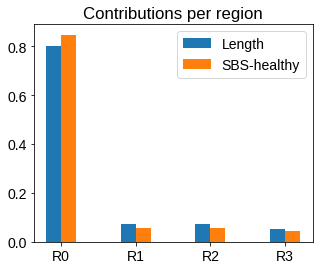

In [21]:
summary_just_stops=pd.DataFrame(list(zip(s['Position'],s['Mutation'],s['Class'],s['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos
summary_just_stops.to_csv('Results/Stops_corrected.csv')


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])


Signature_weights=pd.DataFrame({'Region':['R0','R1','R2','R3']})
Signature_weights['SBS_healthy']=[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3]))


plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'


plt.bar(np.arange(4)-0.1,np.asarray([len(R0),len(R1),len(R2),len(R3)])/len(Rall),.2,label='Length')

plt.bar(np.arange(4)+0.1,[p0,p1,p2,p3],.2,label='SBS-healthy')

plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.title('Contributions per region')
plt.legend()
plt.show()




### 5.2 Healthy SBS per site

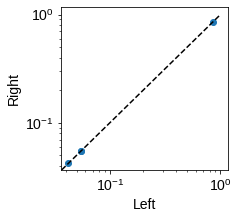

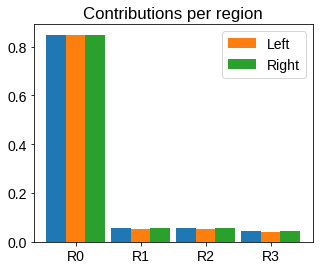

In [24]:

# per site 


summary_just_stops=pd.DataFrame(list(zip(s_right['Position'],s_right['Mutation'],s_right['Class'],s_right['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])

Signature_weights['SBS_healthy_right_colon']=[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3]))


summary_just_stops=pd.DataFrame(list(zip(s_left['Position'],s_left['Mutation'],s_left['Class'],s_left['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])

Signature_weights['SBS_healthy_left_colon']=[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3]))




plt.figure(figsize=(3,3))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.asarray(Signature_weights['SBS_healthy_left_colon']),np.asarray( Signature_weights['SBS_healthy_right_colon']),'o')
plt.xlabel('Left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Right')
plt.plot(np.linspace(0,1,5),np.linspace(0,1,5),'k--')

plt.show()




plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.bar(np.arange(4)-0.3,np.asarray(Signature_weights['SBS_healthy']),0.3)
plt.bar(np.arange(4),np.asarray(Signature_weights['SBS_healthy_left_colon']),0.3,label='Left')

plt.bar(np.arange(4)+0.3,np.asarray(Signature_weights['SBS_healthy_right_colon']),0.3,label='Right')


plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.title('Contributions per region')
plt.legend()
plt.show()



### 5.3 Healthy SBS - individual signature contribution

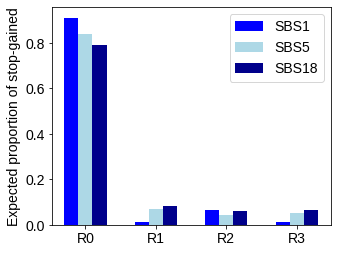

In [25]:
# individual SBS contributions
plt.rcParams['font.family'] = 'Liberation Sans'


envos=sbs['Environment'] # environment signatures
compli=sbs['Compliment'] # compliments
probs_sbs1=sbs['SBS1_GRCh38']/sum(sbs['SBS1_GRCh38']) # relative contribution 
probs_sbs5=sbs['SBS5_GRCh38']/sum(sbs['SBS5_GRCh38']) # relative contribution 
probs_sbs18=sbs['SBS18_GRCh38']/sum(sbs['SBS18_GRCh38']) # relative contribution 

s=mut_probabilties(apc_cds,envos,compli,probs_sbs1)

# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s)):
    n=np.where(s['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s_sbs1= s.filter(items = indices , axis=0)
   
s=mut_probabilties(apc_cds,envos,compli,probs_sbs5)

# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s)):
    n=np.where(s['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s_sbs5= s.filter(items = indices , axis=0)
   
s=mut_probabilties(apc_cds,envos,compli,probs_sbs18)

# keep only mutations that result in stop gained
indices=[]
for i in np.arange(len(s)):
    n=np.where(s['Position'][i]==df['Position'])[0]
    if len(n)>0:
        for m in n:
            if s['Mutation'][i][4]==df['Mutated'][m]:
                indices.append(i)
s_sbs18= s.filter(items = indices , axis=0)


s=mut_probabilties(apc_cds,envos,compli,probs)

plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'




s=s_sbs1


summary_just_stops=pd.DataFrame(list(zip(s['Position'],s['Mutation'],s['Class'],s['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])


plt.bar(np.arange(4)-0.2,[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3])),.2,color='blue',label='SBS1')



s=s_sbs5


summary_just_stops=pd.DataFrame(list(zip(s['Position'],s['Mutation'],s['Class'],s['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])


plt.bar(np.arange(4)+0,[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3])),.2,color='lightblue',label='SBS5')


s=s_sbs18


summary_just_stops=pd.DataFrame(list(zip(s['Position'],s['Mutation'],s['Class'],s['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops['Norm probability']=np.asarray(summary_just_stops['Probability'])/sum(np.asarray(summary_just_stops['Probability']))

summary_just_stops=summary_just_stops.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops['Position']:
    
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops['Region']=pos


p0=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R0'])
p1=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R1'])
p2=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R2'])
p3=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R3'])
p4=sum(summary_just_stops['Norm probability'][summary_just_stops['Region']=='R4'])


plt.bar(np.arange(4)+0.2,[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3])),.2,color='darkblue',label='SBS18')



plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.ylabel('Expected proportion of stop-gained')
plt.legend()
plt.savefig('Results/fig3A.svg',dpi=300)
plt.show()






### 5.4 Combine results for POLE and MSI signatures

In [26]:
#for pole
summary_just_stops_p=pd.DataFrame(list(zip(s_pole['Position'],s_pole['Mutation'],s_pole['Class'],s_pole['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops_p['Norm probability']=np.asarray(summary_just_stops_p['Probability'])/sum(np.asarray(summary_just_stops_p['Probability']))

summary_just_stops_p=summary_just_stops_p.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops_p['Position']:
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops_p['Region']=pos
summary_just_stops_p.to_csv('Results/Stops_corrected_POLE.csv')



p0=sum(summary_just_stops_p['Norm probability'][summary_just_stops_p['Region']=='R0'])
p1=sum(summary_just_stops_p['Norm probability'][summary_just_stops_p['Region']=='R1'])
p2=sum(summary_just_stops_p['Norm probability'][summary_just_stops_p['Region']=='R2'])
p3=sum(summary_just_stops_p['Norm probability'][summary_just_stops_p['Region']=='R3'])
p4=sum(summary_just_stops_p['Norm probability'][summary_just_stops_p['Region']=='R4'])
Signature_weights['SBS_POLE']=[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3]))



summary_just_stops_msi_GEL=pd.DataFrame(list(zip(s_msi_GEL['Position'],s_msi_GEL['Mutation'],s_msi_GEL['Class'],s_msi_GEL['Probability'])),
                   columns =['Position','Mutation','Class','Probability'])
summary_just_stops_msi_GEL['Norm probability']=np.asarray(summary_just_stops_msi_GEL['Probability'])/sum(np.asarray(summary_just_stops_msi_GEL['Probability']))

summary_just_stops_msi_GEL=summary_just_stops_msi_GEL.sort_values(by=['Position'])

pos=[]
for p in summary_just_stops_msi_GEL['Position']:
    if p in np.arange(0,1256*3):
        pos.append('R0')
    elif p in np.arange(1256*3,1370*3):
        pos.append('R1')
    elif p in np.arange(1370*3,1486*3):
        pos.append('R2')
    elif p in np.arange(1486*3,1569*3):
        pos.append('R3')
    else:
        pos.append('R4')
summary_just_stops_msi_GEL['Region']=pos
summary_just_stops_msi_GEL.to_csv('Results/Stops_corrected_MSI.csv')


p0=sum(summary_just_stops_msi_GEL['Norm probability'][summary_just_stops_msi_GEL['Region']=='R0'])
p1=sum(summary_just_stops_msi_GEL['Norm probability'][summary_just_stops_msi_GEL['Region']=='R1'])
p2=sum(summary_just_stops_msi_GEL['Norm probability'][summary_just_stops_msi_GEL['Region']=='R2'])
p3=sum(summary_just_stops_msi_GEL['Norm probability'][summary_just_stops_msi_GEL['Region']=='R3'])
p4=sum(summary_just_stops_msi_GEL['Norm probability'][summary_just_stops_msi_GEL['Region']=='R4'])
Signature_weights['SBS_MSI']=[p0,p1,p2,p3]/sum(np.asarray([p0,p1,p2,p3]))



### 5.5 Import IDs Analysis results and plot combined results

In [30]:
ids_healthy=pd.read_csv('Results/IDS_weights.csv')['IDS_healthy']
ids_MSI=pd.read_csv('Results/IDS_weights.csv')['IDS_MSI']
ids_left=pd.read_csv('Results/IDS_weights.csv')['IDS_healthy_Left']
ids_right=pd.read_csv('Results/IDS_weights.csv')['IDS_healthy_Right']

Signature_weights['IDS_healthy']=ids_healthy
Signature_weights['IDS_healthy_Left']=ids_left
Signature_weights['IDS_healthy_Right']=ids_right

Signature_weights['IDS_MSI']=ids_MSI
Signature_weights.to_csv('Results/All_signatures_weights.csv')

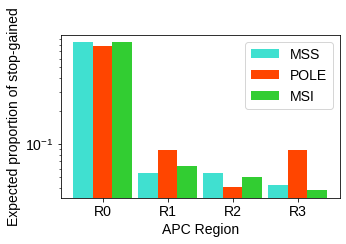

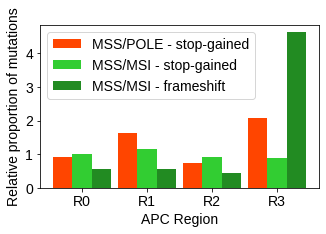

In [28]:

plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.bar(np.arange(4)-0.3, Signature_weights['SBS_healthy'],0.3,color='turquoise',label='MSS')
plt.bar(np.arange(4), Signature_weights['SBS_POLE'],0.3,color='orangered',label='POLE')
plt.bar(np.arange(4)+0.3, Signature_weights['SBS_MSI'],0.3,color='limegreen',label='MSI')


plt.ylabel('Expected proportion of stop-gained')
plt.xlabel('APC Region')

plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.legend()
plt.yscale('log')
plt.show()


plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'



plt.bar(np.arange(4)-0.3, Signature_weights['SBS_POLE']/Signature_weights['SBS_healthy'],0.3,color='orangered',label='MSS/POLE - stop-gained')
plt.bar(np.arange(4)+0, Signature_weights['SBS_MSI']/Signature_weights['SBS_healthy'],0.3,color='limegreen',label='MSS/MSI - stop-gained')
plt.bar(np.arange(4)+0.3, Signature_weights['IDS_MSI']/Signature_weights['IDS_healthy'],0.3,color='forestgreen',label='MSS/MSI - frameshift')

plt.ylabel('Relative proportion of mutations')
plt.xlabel('APC Region')
desired_ticks = [0,1,2,3,4]# 20, 30]
plt.yticks(desired_ticks)
plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.legend()
plt.savefig('Results/fig6A.svg',dpi=300)
plt.show()

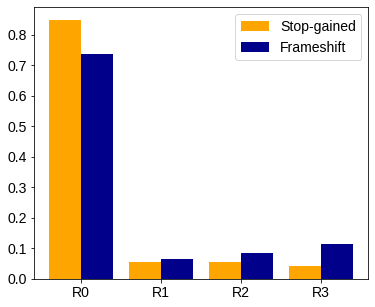

In [29]:

plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'Liberation Sans'



plt.bar(np.arange(4)-0.2, Signature_weights['SBS_healthy'],0.4,color='orange',label='Stop-gained')
plt.bar(np.arange(4)+0.2, Signature_weights['IDS_healthy'],0.4,color='darkblue',label='Frameshift')

plt.xticks(np.arange(4), ['R0','R1','R2','R3'])
plt.legend()
plt.savefig('Results/fig6A.svg',dpi=300)
plt.show()